In [1]:
from init import *
import os
import numpy as np
import cv2
from torch import nn
import torch.nn.functional as F
import torch
from torch import optim
from torch import nn
from tqdm import tqdm
from lossers import dice_loss,center_loss
import  torchvision
from modules.operates.ops import conv3x3,conv1x1,residualBlock
from modules.blocks.yolo_blocks import C3, Conv
from modules.blocks.blocks import OutConv
from modules.blocks.input_blocks import MultiKernelInput,CovAndHW,Fusion2Branch,Fusion3Branch

RUNDIR: runs/log/80971


In [2]:
class Fusion2Backbone(nn.Module):
    def __init__(self,c1,ns=[],ss=[],c_size=True):
        super(Fusion2Backbone,self).__init__()
        
        self.seq = nn.Sequential()
        self.seq1 = nn.Sequential()
        self.seq2 = nn.Sequential()
        c=c1
        for i,(n,s) in enumerate(zip(ns,ss)):
            subseq = nn.Sequential()
            for _ in range(n):
                subseq.add_module('c3_'+str(i)+'_'+str(_),C3(c1,c,1))
            
            if not c_size: c*=s
            self.seq.add_module('subseq_'+str(i),subseq)
            self.seq1.add_module('c1_'+str(i),Conv(c1,c,k=3,s=s,p=1))
            c1=c
            
            self.seq2.add_module('c1_'+str(i),Conv(c1*2,c1,k=3,s=1,p=1))
        self.cov_act1 = Cov_Act(c1,c,3,1,1)
        self.cov_act2 = Cov_Act(c1,c,3,1,1)
        
    def forward(self,x1,x2):
        for m,m1,m2 in zip(self.seq,self.seq1,self.seq2):
            x1 = m(x1)
            y1 = m1(x1)
            
            x2 = m(x2)
            y2 = m1(x2)
            x1 = torch.cat([y1,y2],1)
            x2 = torch.cat([y2,y1],1)
            
            x1 = m2(x1)
            x2 = m2(x2)
            x1 = self.cov_act1(x1)
            x2 = self.cov_act2(x2)
        return x1,x2
    
class Cov_Act(nn.Module):
    def __init__(self,c1,c2,k,s,p):
        super(Cov_Act,self).__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, p, groups=1, bias=False)
        # self.bn = nn.BatchNorm2d(c2,eps=0.001,momentum=0.03)
        self.act = nn.SiLU()
    def forward(self,x):
        x = self.conv(x)
        x = self.act(x)
        return x



class Model(nn.Module):
    def __init__(self, ch=3):
        super(Model, self).__init__()
        self.ch=ch
        self.m_ch = 32
        self.out_ch=3
        self.MI = MultiKernelInput(3, self.m_ch)
        self.model = nn.Sequential()
        self.fb = Fusion2Backbone(self.m_ch,ns=[6,1,1,6,1,1],ss=[1,1,1,1,1,1])
        self.cov1 =  Conv(self.m_ch,int(self.m_ch/2),3,1,1)
        self.cov2 =  Conv(self.m_ch,int(self.m_ch/2),3,1,1)
        self.out1 = OutConv(int(self.m_ch/2),self.out_ch)
        self.out2 = OutConv(int(self.m_ch/2),self.out_ch)
        
    def forward(self, x1=None,x2=None):
        if x2 is None:  x2 = x1.copy()
        x1 = self.MI(x1)
        x2 = self.MI(x2)        
        x1,x2 = self.fb(x1,x2)
        x1 = self.cov1(x1)
        x2 = self.cov2(x2)
        x1 = self.out1(x1)
        x2 = self.out2(x2)
        return x1,x2
    
# blocks=[conv3x3,residualBlock,conv3x3,residualBlock,conv3x3,residualBlock,conv3x3], repeats=[1,3,1,3,1,3,1],downs=[1,1,2,1,1,1,1]
# model = Model(3)
# imgs = torch.zeros((1,3,640,640))
# r1,r2 = model(imgs,imgs)
# print(r1.shape)

In [3]:
cfg0['data']['path']=r'/home/wanghaifeng/project_work/datasets/changedetection_dataset/zaihai/imgs8'

In [4]:
resize = torchvision.transforms.Resize((320,320), interpolation=2)

# torch.cuda.empty_cache()
device = 'cuda:3'
epochs=500 

model = Model(3).to(device).train()

cfg0['training']['batch_size']=4
cfg0['data']['img_rows']=640
cfg0['data']['img_cols']=640
cfg0['training']['optimizer']['lr']=0.001

n_claess,train_loader, val_loder = get_dataloader(cfg0)
optimizer, scheduler = get_optimizer_scheduler(model)

/home/wanghaifeng/.local/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


no exits
no exits
no exits
no exits


In [4]:
# criterion = nn.MultiLabelSoftMarginLoss()

# for epoch  in  range(epochs): 
#     losses =[]
#     # optimizer.zero_grad()
#     for images in train_loader:
#         optimizer.zero_grad()
        
        
#         loss.backward()
#         optimizer.step()
#         scheduler.step()

#         losses.append(loss.detach().cpu().numpy())

#     print('epoch'+str(epoch)+' :', np.sum(losses)/len(losses))

In [24]:
    learning_rate: float = 1e-5
    amp = False
    epochs=500
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.MultiLabelSoftMarginLoss()


    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0
        with tqdm(total=100, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            losss=[]
            for images in train_loader:
                t1 = images['t1'].to(device)#.half()
                t2 = images['t2'].to(device)#.half()

                t1_b = images['mask2_b'].to(device)#.half()
                t2_b = images['mask2_b'].to(device)#.half()
                t1_b[t1_b>0]=1.0
                t2_b[t2_b>0]=1.0
                t1_b = t1_b.to(device,dtype=torch.long)#.half()
                t2_b = t2_b.to(device,dtype=torch.long)#.half()t1_b = t1_b.to(device,dtype=torch.long)#.half()
                with torch.cuda.amp.autocast(enabled=amp):
                    r1,r2 = model(t1,t2)
                    
                    t1_b = resize(t1_b)
                    t2_b = resize(t2_b)
                    loss = (criterion(r1,t1_b)\
                                       + dice_loss(F.softmax(r1, dim=1).float(),
                                                   F.one_hot(t1_b.squeeze(1), 3).permute(0, 3, 1, 2).float(),
                                                   multiclass=True)\
                            +criterion(r2,t2_b)\
                                       + dice_loss(F.softmax(r2, dim=1).float(),
                                                   F.one_hot(t2_b.squeeze(1), 3).permute(0, 3, 1, 2).float(),
                                                   multiclass=True))/2.0

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()
                losss.append(loss.item())
                pbar.update(t1.shape[0])
                pbar.set_postfix(**{'loss (batch)': loss.item()})
            pbar.set_postfix(**{'loss (epoch)': sum(losss)/len(losss)})  

Epoch 1/500: 2059img [03:57,  8.65img/s, loss (epoch)=12.3]                       
Epoch 2/500: 2059img [03:57,  8.69img/s, loss (epoch)=11.2]                       
Epoch 3/500: 2059img [03:55,  8.75img/s, loss (epoch)=10.3]                       
Epoch 4/500: 2059img [03:54,  8.76img/s, loss (epoch)=9.42]                       
Epoch 5/500: 2059img [03:55,  8.76img/s, loss (epoch)=8.63]                       
Epoch 6/500: 2059img [03:54,  8.80img/s, loss (epoch)=7.89]                       
Epoch 7/500: 2059img [03:55,  8.74img/s, loss (epoch)=7.2]                        
Epoch 8/500: 2059img [03:54,  8.76img/s, loss (epoch)=6.57]                       
Epoch 9/500: 2059img [03:55,  8.76img/s, loss (epoch)=6.01]                       
Epoch 10/500: 2059img [03:56,  8.69img/s, loss (epoch)=5.54]                       
Epoch 11/500: 2059img [03:54,  8.77img/s, loss (epoch)=5.08]                       
Epoch 12/500: 2059img [03:55,  8.74img/s, loss (epoch)=4.67]                       
E

KeyboardInterrupt: 

In [ ]:
# torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(6)/1024/1024/1024)
# torch.cuda.synchronize()
# print(torch.cuda.memory_summary(6))

In [36]:
torch.save(model,'test5.pt')

In [18]:
#             for images in train_loader:
#                 t1 = images['t1']
#                 t2 = images['t2']

#                 t1_b = images['mask1_b']
#                 t2_b = images['mask2_b']
                
#                 print(t2_b.shape)
#                 print(t2_b.max(),t2_b.min())

In [25]:
def show(t1_b):
    img = t1_b[0]
    img = img.detach().cpu().numpy()
    img = img.transpose(1,2,0)
    # img = (img-img.min())/img.max()
    # img*=255
    # img = img.astype(np.uint8)
    return img

In [30]:
t2.shape

torch.Size([4, 3, 640, 640])

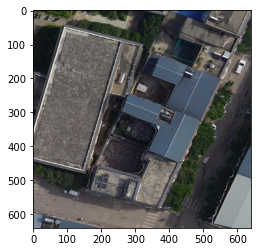

In [31]:
import matplotlib.pyplot as plt

img = show(t2[1:2])
plt.imshow(img)

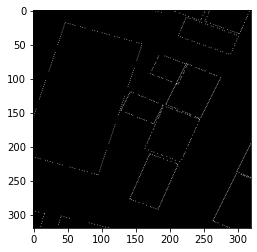

In [32]:
img = show(t2_b[1:2])
# img[img>10]=[255]
plt.imshow(img,'gray')

In [12]:
# cv2.imwrite('test.png',img)
# torch.save(fb,'test.pt')

True

In [33]:
probs = F.softmax(r1, dim=1)
img1 = torch.argmax(probs,1)

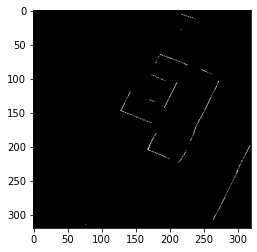

In [35]:
plt.imshow(img1[1].detach().cpu().numpy()*255,'gray')

In [47]:
from  glob  import glob
imgs = glob(r'/home/wanghaifeng/project_work/datasets/changedetection_dataset/zaihai/imgs7/train/t2/*.png')
zaihai/imgs8

In [48]:
img = cv2.imread(imgs[2])
img = cv2.resize(img,(1280,1280))
img = img.transpose(2,0,1)
img = np.array([img])
img = torch.from_numpy(img).to(device)
img = img/255

In [49]:
model = model.eval()
with torch.no_grad():
    r = model(img,img)

In [50]:
def show_result(r1):
    probs = F.softmax(r1, dim=1)
    img1 = torch.argmax(probs,1)
    img1 = img1[0].detach().cpu().numpy()*255
    return  img1

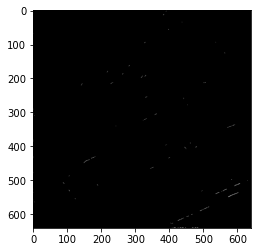

In [51]:
plt.imshow(show_result(r[1]),'gray')

In [1]:
29.7263-0.1,102.279-0.1, 29.7263+0.1,102.279+0.1

(29.626299999999997, 102.179, 29.8263, 102.37899999999999)